<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Очистка-и-лемматизация-текста" data-toc-modified-id="Очистка-и-лемматизация-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка и лемматизация текста</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Векторизация-текста" data-toc-modified-id="Векторизация-текста-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Векторизация текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-дерева-решений" data-toc-modified-id="Модель-дерева-решений-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель дерева решений</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# перейдем в широкоформатный режим  Jupyterи
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# загрузим библиотеку для лемматизации
!pip install -q spacy
import spacy
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 1.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# импортируем необходимые библиотеки
import os
import re
import pickle
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm 

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords as nltk_stopwords
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
# начальное состояние генератора случайных чисел
RANDOM_STATE = 12345

### Обзор данных

In [5]:
# считаем датафрейм
data = pd.read_csv('/datasets/toxic_comments.csv')

In [6]:
# напишем функцию, выполняющую первичный анализ данных
def overview_data(data):
    # выведем первые 20 строк
    display(data.head(20))
    # выведем информацию о датафрейме
    data.info()
       
    # построим общую гистограмму для всех числовых признаков
    data.hist(figsize=(10, 10), bins=20);
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()
    
    # выведем описание данных
    display(data.describe())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


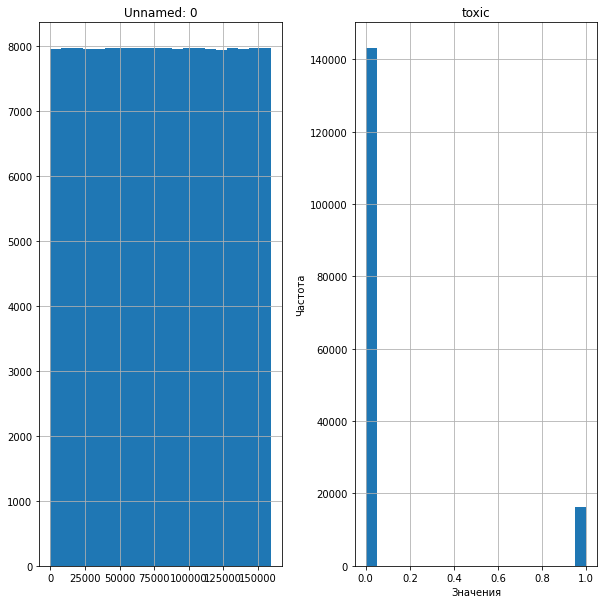

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [7]:
# выполним первичный анализ данных для датафрейма
overview_data(data)

Столбец 'Unnamed: не информативен, поэтому удалим его:

In [8]:
data = data.drop('Unnamed: 0', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


<div style="border:solid green 2px; padding: 20px">

* Данные содержат комментарии и целевой признак - является ли комментарий токсичным.
* Столбец `Unnamed: 0` удалён, так как он не информативен.
* Пропусков в данных нет.
* Судя по описанию данных, доля токсичных комментариев в датафрейме: 10%.
    
</div>

### Очистка и лемматизация текста

Для корректных результатов анализа комментариев приведем их к нижнему регистру, удалим из них символы  и лемматизируем их:

In [9]:
# добавим функцию, выполняющую очистку текста
def clear_text(text):
    clean_test = re.sub(r'[^a-zA-Z ]', ' ', text) 
    return ' '.join(clean_test.split())

# загрузим модель английского языка для обработки текста
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# добавим функцию, выполняющую лемматизацию текста
def lemmatize(text):
    doc = nlp(text)
    # Выполните лемматизацию для каждого токена
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

In [10]:
# приведем текст к нижнему регистру
data['text'] = data['text'].str.lower()

# применим функцию clear_text к каждой строке столбца 'text'
data['text'] = data['text'].apply(clear_text)

In [11]:
# применим функцию лемматизации текста с отображением прогресс-бара, так как операция длительная
tqdm.pandas()
data['text'] = data['text'].progress_apply(lemmatize)

display(data.head())

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,more I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Так как процесс лемматизации занимает много времени, сохраним в файл результат лемматизации, чтобы не ждать результаты ее применения при каждом запуске:

In [12]:
# добавим функцию, сохраняющую лемматизированные тексты в файл
def storeData(data):
    dbfile = open('Lemmatized_texts', 'wb')
    pickle.dump(data, dbfile)                   
    dbfile.close()

# добавим функцию, считывающие лемматизированные текстыы из файла в data
def loadData():
    dbfile = open('Lemmatized_texts', 'rb')   
    data = pickle.load(dbfile)
    for keys in data:
        print(keys, '=>', data[keys])
    dbfile.close()
    return data

# раскомментировать, чтобы сохранить лемматизированные тексты в файл
# storeData(data)

# раскомментировать, чтобы загрузить лемматизированные тексты из файла
# data = loadData()
# data.head()

text => 0         explanation why the edit make under my usernam...
1         d aww he match this background colour I m seem...
2         hey man I m really not try to edit war it s ju...
3         more I can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm there s no actual article for pros...
159290    and it look like it be actually you who put on...
159291    and I really don t think you understand I come...
Name: text, Length: 159292, dtype: object
toxic => 0         0
1         0
2         0
3         0
4         0
         ..
159287    0
159288    0
159289    0
159290    0
159291    0
Name: toxic, Length: 159292, dtype: int64


,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,more I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


### Подготовка выборок

In [34]:
features = data.drop('toxic', axis=1)
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.25, random_state=RANDOM_STATE)

# проверим, что выборки получились нужного размера
features_train.shape

(119469, 1)

### Векторизация текста

Проведем векторизацию, вычисляя TF-IDF для корпуса текстов. Укажем также стоп-слова, т.е слова без смысловой нагрузки, которые нужно удалить из текстов:

In [35]:
stopwords = set(nltk_stopwords.words('english'))

tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords, dtype=np.float32, max_features=15000)

# обучим и применим TfidfVectorizer на тренировочной выборке
tf_idf_train = tf_idf_vectorizer.fit_transform(features_train['text'].values)

td_idf_features_train = pd.DataFrame.sparse.from_spmatrix(data=tf_idf_train, columns=tf_idf_vectorizer.get_feature_names())

# посмотрим, сколько признаков получилось после векторизации
td_idf_features_train.shape

(119469, 15000)

In [36]:
# обучим и применим TfidfVectorizer на тренировочной выборке
tf_idf_train_row = tf_idf_vectorizer.fit_transform(features_train['text'].values)
dtr_model = LogisticRegression(solver='saga', C =10) 
dtr_model.fit(tf_idf_train_row, target_train)

LogisticRegression(C=10, solver='saga')

In [37]:
type(tf_idf_train_row)

scipy.sparse._csr.csr_matrix

In [38]:
# выполним векторизацию на тестовой выборке
tf_idf_test = tf_idf_vectorizer.transform(features_test['text'].values)

td_idf_features_test = pd.DataFrame.sparse.from_spmatrix(data=tf_idf_test, columns=tf_idf_vectorizer.get_feature_names())

# посмотрим, сколько признаков получилось после векторизации
td_idf_features_test.shape

(39823, 15000)

<div style="border:solid green 2px; padding: 20px">

* В рамках предобработки комментариев привели их к нижнему регистру, удалили из них символы  и лемматизировали их.
* Убрали из комментариев стоп-слова, т.е слова без смысловой нагрузки.
* Выполнили векторизацию текстов, вычисляя для них TF-IDF.
* Так как процесс лемматизации занимает много времени, добавили функции, сохраняющую в файл результат лемматизации и считывающие его из файла, чтобы не ждат результаты ее применения при каждом запуске.
    
</div>

## Обучение

Для упрощения напишем функцию, которая с помощью RandomizedSearchCV подбираем лучшую модель по метрике F1 среди переданных параметров:

In [39]:
def find_best_model(model, parameters):
    grid_search = RandomizedSearchCV(
        model, parameters, scoring='f1', cv=3, n_iter=10, n_jobs=-1, error_score = 'raise')
    grid_search.fit(td_idf_features_train, target_train)

    print('Наилучшая модель', grid_search.best_params_)
    print('F1 наилучшей модели', abs(grid_search.best_score_))
    
    return grid_search.best_estimator_, abs(grid_search.best_score_)

### Модель дерева решений

Воспользуемся DecisionTreeClassifier для поиска наилучшей модели дерева решений по метрике F1:

In [40]:
%%time
dtr_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtr_parameters = {'max_depth': range(5,21, 5), 'min_samples_split': range(5, 21, 5), 'min_samples_leaf': range(5, 21, 5)}

dtr_best_estimator, dtr_best_score = find_best_model(dtr_model, dtr_parameters)

Наилучшая модель {'min_samples_split': 15, 'min_samples_leaf': 20, 'max_depth': 20}
F1 наилучшей модели 0.6708169052782412
CPU times: user 22min 33s, sys: 1.23 s, total: 22min 34s
Wall time: 22min 35s


### Модель случайного леса

Воспользуемся RandomForestClassifier для поиска наилучшей модели случайного дерева по метрике F1:

In [41]:
%%time
rfr_model = RandomForestClassifier(random_state=RANDOM_STATE)
rfr_parameters = {"n_estimators": [100, 200], 'max_depth': [None, 8, 12, 16]}

rfr_best_estimator, rfr_best_score = find_best_model(rfr_model, rfr_parameters)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшая модель {'n_estimators': 200, 'max_depth': None}
F1 наилучшей модели 0.7537217339459499
CPU times: user 49min 58s, sys: 3.08 s, total: 50min 1s
Wall time: 50min 3s


### Логистическая регрессия

In [42]:
%%time
lr_model = LogisticRegression(solver='liblinear', dual=True, max_iter = 1000)
lr_parameters = {'C': range(5, 13, 1)}

lr_best_estimator, lr_best_score = find_best_model(lr_model, lr_parameters)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшая модель {'C': 9}
F1 наилучшей модели 0.774324900805451
CPU times: user 17min 48s, sys: 1.41 s, total: 17min 49s
Wall time: 17min 50s


<div style="border:solid green 2px; padding: 20px">
    
* Наилучший результат по метрике F1 выдала модель логистической регрессии: 0.765. Далее идет модель случайного леса с F1 0.759. Наихудший результат F1 у модели дерева решений 0.65.
* Для решения задачи классификации комментариев по токсичности выберем модель логистической регрессии.

</div>

## Тестирование

### Тестирование лучшей модели

Проверим, как лучшая модель отрабатывает на тестовой выборке:

In [43]:
# определим функцию, вычиляющую F1 модели на тестовой выборке
def test_model(best_estimator):
    predictions_test = best_estimator.predict(td_idf_features_test)

    f1_test =  f1_score(target_test, predictions_test)
    print('Итоговый F1 на тестовой выборке', f1_test) 

In [44]:
# протестируем модель логистической регрессии
test_model(lr_best_estimator)

Итоговый F1 на тестовой выборке 0.7806752676365633


### Проверка на адекватность

Сравним, как соотносятся полученные результаты с результатами фиктивного классификатора, который будет прогнозировать классы в соответствии с их относительными частотами в исходных данных:

In [45]:
dr_model = DummyClassifier(strategy='stratified')
dr_parameters = {}

dr_best_estimator, dr_best_score = find_best_model(dr_model, dr_parameters)
test_model(dr_best_estimator)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшая модель {}
F1 наилучшей модели 0.10294597357046927
Итоговый F1 на тестовой выборке 0.0948636028508233


<div style="border:solid green 2px; padding: 20px">
    
* Наилучшая модель логистической регрессии на тестовой выборке вычислила F1 0.772, что очень близко к результату на тренировочной выборке: 0.765 Это означает, что модель не переобучилась.
* Сравнили результат наилучшей найденной модели логистической регрессии с фиктивным классификатором, который прогнозирует классы в соответствии с их относительными частотами в исходных данных. На тестовой выборке модель логистической регрессии показала F1 0.772, а фиктивный регрессор 0.103, что заметно лучше. В отличие от фиктивного классификатора модель логистической регрессии превосходит требуемое в задаче значение F1 на тестовой выборке не больше 0.75.
    
</div>

## Общие выводы

<div style="border:solid green 2px; padding: 20px">
    
* В проекте **требовалось построить модель для интернет-магазина, которая будет искать токсичные комментарии к описаниям товаров**, чтобы затем отправлять их на модерацию.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Данные содержат комментарии и целевой признак - является ли комментарий токсичным.
* Столбец `Unnamed: 0` удалили, так как он не информативен.
* Пропусков в данных нет.
* Судя по описанию данных, доля токсичных комментариев в датафрейме: 10%.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* В рамках предобработки комментариев привели их к нижнему регистру, удалили из них символы  и лемматизировали их.
* Убрали из комментариев стоп-слова, т.е слова без смысловой нагрузки.
* Выполнили векторизацию текстов, вычисляя для них TF-IDF.
* Так как процесс лемматизации занимает много времени, добавили функции, сохраняющую в файл результат лемматизации и считывающие его из файла, чтобы не ждать результаты ее применения при каждом запуске.   
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------   
* **Наилучший результат по метрике F1 выдала модель логистической регрессии: 0.765.** Далее идет модель случайного леса с F1 0.759. Наихудший результат F1 у модели дерева решений 0.65.
* Для решения задачи классификации комментариев по токсичности **выбрали модель логистической регрессии**.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Наилучшая **модель логистической регрессии на тестовой выборке вычислила F1 0.772**, что очень близко к результату на тренировочной выборке: 0.765 Это означает, что модель не переобучилась.
* Сравнили результат наилучшей найденной модели логистической регрессии с фиктивным классификатором, который прогнозирует классы в соответствии с их относительными частотами в исходных данных. На тестовой выборке модель логистической регрессии показала F1 0.772, а фиктивный регрессор 0.103, что заметно лучше. В отличие от фиктивного классификатора **модель логистической регрессии превосходит требуемое в задаче значение F1 на тестовой выборке не больше 0.75.**
</div>